First. Product Owner have to choose between two KPIs (group of metrics) of his product and invest in one of possible strategies. Ads or CRO, attraction or retention, etc. Second. PO tries to make KPI as simple as possible. Here I use ML scores of prediction as a measure of KPI selection and simplification. I look at two groups of metrics which help to predict sales opportunities. ML scoring may be a solution when nonlinearity exists (conversion-traffic have mutual relationship) or ditribution of nonsystematic mystakes is far from normal distribution. In these cases correlations, Granger tests, PCA give poor results. Supervised nonlinear ML models sometimes give insight.

Standard statistical measures can be enforced by nonlinear ML models. Ensemble voting, binning of target and dimension reduction are involved. I explore two groups of metrics. First (I) corresponds to conversion - bounce rate, depth of views, micro conversion. Second (II) corresponds to traffic: number of sessions, new visitors, views. The target function is a number of commercial offers per day converted into the sale. Input features correspond to the >New Visitors segment from organic search< 

In [1]:
import numpy as np 
import pandas as pd 
from pandas import set_option
import matplotlib.pyplot as plt 
from pylab import plot, ylim, xlim, show, xlabel, ylabel, grid 
from numpy import linspace, loadtxt, ones, convolve
from statistics import median 
from statistics import mean 
from statistics import stdev 
from math import log
from numpy.polynomial.polynomial import polyfit
from sklearn.model_selection import cross_val_score 
from sklearn.model_selection import GridSearchCV 
from sklearn.model_selection import KFold 
from sklearn.decomposition import PCA
from sklearn.linear_model import Ridge
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import VotingClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.ensemble import GradientBoostingClassifier
import statsmodels.api as sm
from sklearn.model_selection import train_test_split
from operator import add
import seaborn as sns
from sklearn.tree import DecisionTreeRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.ensemble import RandomForestRegressor
from mlxtend.regressor import StackingRegressor
from sklearn.linear_model import LinearRegression

Define custom functions:

In [2]:
def standart(x):#normalize to (0,1) interval
    max_value=x.max();
    min_value=x.min()
    z=(x-min_value)/(max_value - min_value)
    return z

def cormap(x):#correlation map
  corr=x.corr();fig=plt.figure(figsize=(10, 7))
  g=sns.heatmap(corr,annot=True,linewidths=.2, cbar_kws={"orientation": "horizontal"})
  plt.show()
    
def get_class(x):
    class_type=[]
    for item in list(x):
        if 0<=item<0.2:   class_type.append(0) #1 class  
        if 0.2<=item<0.4: class_type.append(1) #2 class
        if 0.4<=item<0.6:  class_type.append(2) #3 class
        if 0.6<=item<0.8:  class_type.append(3) #4 class
        if 0.8<=item<=1:  class_type.append(4) #5 class     
    return class_type

Read data from three files with crm and web data, parsed by webparse script from web analytics platform API.   

In [3]:
df_all=pd.read_excel('DATA_RET/TRAFFIC.xlsx') #general web metrics
df_goal=pd.read_excel('DATA_RET/WEB_CR.xlsx') #web conversion rate
df_crm=pd.read_excel('DATA_RET/OFF_CR.xlsx') #commercial offers

df=df_all.merge(df_goal,how='left',left_on='Date',right_on='Date')#inner join of general web metrics and conversion metrics

del df['Viewers_y'];del df['Views_y'];del df['BR_y'];del df['Depth_y'];del df['Time_y'];df=df.fillna(0)
df['CR,%']=100*df['Visits_y']/df['Visits_x'];del df['Visits_y'] #calculate conversion rate
df=df.merge(df_crm,how='left',left_on='Date',right_on='Date') #inner join with crm data - offers per day and date
df['Offers']=df['Offers'].fillna(0);# rename the column

Rename columns.

In [4]:
df['Visits']=df['Visits_x'];df['Viewers']=df['Viewers_x']
df['Views']=df['Views_x'];del df['Visits_x'];del df['Viewers_x'];del df['Views_x'];del df['Time_x']

df['BR']=df['BR_x'];df['Depth']=df['Depth_x'];
df['CR']=df['CR,%'];del df['BR_x'];del df['Depth_x'];del df['CR,%']

df['OFFERS_CR']=df['Offers'];del df['Offers']
df=df.dropna()
print(df.head())

        Date  Visits  Viewers  Views   BR  Depth     CR  OFFERS_CR
0 2015-05-05       1        1      3  0.0    3.0  100.0        2.0
1 2015-05-07       1        1      2  0.0    2.0    0.0        0.0
2 2015-05-08       2        2     14  0.0    7.0   50.0        1.0
3 2015-05-12       1        1      7  0.0    7.0  100.0        1.0
4 2015-05-15       1        1      1  0.0    1.0    0.0        1.0


In [5]:
column_names=list(df.columns.values)
print('All fields:',column_names)
print('\nData Start:',list(df['Date'])[0])
print('Data End:',list(df['Date'])[-1])
print('Number of records:', len(df))

All fields: ['Date', 'Visits', 'Viewers', 'Views', 'BR', 'Depth', 'CR', 'OFFERS_CR']

Data Start: 2015-05-05 00:00:00
Data End: 2019-06-22 00:00:00
Number of records: 1321


Convert features to the (0,1) interval except date:

In [6]:
date_list=list(df['Date'])
del df['Date']  

for item in df.columns.values: 
    df[item]=standart(df[item])         

Make correlation map and scatter map

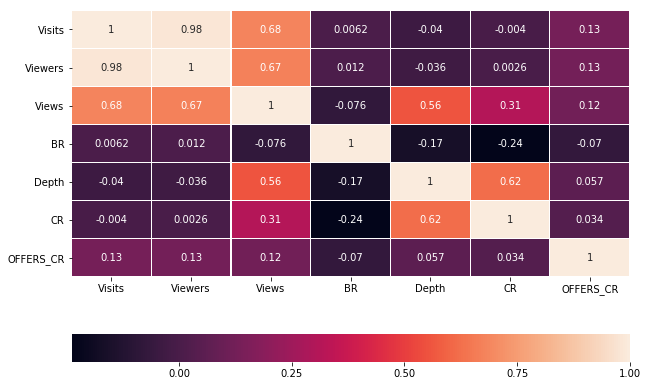

In [7]:
cormap(df)

Correlations of OFFERS, converted into the sale, are non significant by absolute value. However we may notice that Depth and CR; Visits/Viwers/Views are highly correlated. It may be used for the dimension reduction. Let's look at the basic statistical properties of 'OFFERS_CR' data. 

In [8]:
description=df['OFFERS_CR'].describe()
print('Common description:\n')
print(description)
print('\nPercentile of 80%:',round(df['OFFERS_CR'].quantile(0.9),2))

Common description:

count    1321.000000
mean        0.103169
std         0.171169
min         0.000000
25%         0.000000
50%         0.000000
75%         0.142857
max         1.000000
Name: OFFERS_CR, dtype: float64

Percentile of 80%: 0.29


PMF is skewed. However we still may try to split (0,1) interval into 5 equal classes - naive binning. 

In [9]:
df_binary=df.copy()
df_binary['Offers_BIN']=get_class(df_binary['OFFERS_CR'])
del df_binary['OFFERS_CR']

If classiicator works well we may predict in what range the target lays. Let's split features and target. Let's make an estimation of feature importance based on tree classifier. 

In [10]:
model=ExtraTreesClassifier(n_estimators=1000)
tree_features=['Visits','Viewers','Views','BR','Depth','CR','OFFERS_CR']

array=df_binary.values
X=array[:,0:6];Y=array[:,6]
model.fit(X,Y)
imp=list(model.feature_importances_)
imp=[round(x*100/max(imp)) for x in imp]

print('\nInput of components - Tree:')  
for x,y in zip(tree_features,imp): 
    print(str(x)+':'+str(y)+'%')


Input of components - Tree:
Visits:45.0%
Viewers:60.0%
Views:99.0%
BR:62.0%
Depth:100.0%
CR:64.0%


According to the TreeEstimator Depth/Views/CR have the highest influence. Conversion group of metrics has the higher weight. Now we can move forward to the ensemble of simple classifiers/predictors. First try with all features. We use ensemble of 6 voting estimators. 

In [11]:
split_num=5 #number of splits for cross validation

#define split test#
X_train,X_test,Y_train,Y_test=train_test_split(X,Y,test_size=0.5)
#/define split test#

#building the ensemble#
model=KNeighborsClassifier()
n_neighbors=np.arange(5,20,1)
param_grid=dict(n_neighbors=n_neighbors)
grid=GridSearchCV(estimator=model,param_grid=param_grid,cv=split_num,iid=True)
grid.fit(X, Y)

kn=KNeighborsClassifier(n_neighbors=grid.best_estimator_.n_neighbors);gb=GaussianNB()
dt=DecisionTreeClassifier(criterion='entropy');sv=SVC(gamma='auto')
ab=AdaBoostClassifier(n_estimators=100,random_state=7)
gb=GradientBoostingClassifier(n_estimators=100,random_state=7)
mlp=MLPClassifier(activation='relu', hidden_layer_sizes=(3,1), random_state=1, solver='lbfgs')

estimators=[]
estimators.extend([('kn',kn),('naive',gb),('dt',dt),('sv',sv),('ab',ab),('gb',gb),('mlp',mlp)])
ensemble=VotingClassifier(estimators)
#/building the ensemble#
   
#output of results#
results=cross_val_score(ensemble,X,Y,cv=split_num)
ensemble.fit(X_train,Y_train);score=ensemble.score(X_test,Y_test)
print('Accuracy of out-of-sample 50/50 test='+str(round(100*score))+'%')
print('Average score:'+str(round(100*mean(results),1))+str('%'))
print('Deviation of score:'+str(round(100*stdev(results),1))+str('%'))
#/output of results#

Accuracy of out-of-sample 50/50 test=80.0%
Average score:79.6%
Deviation of score:0.4%


Great. Now remove all features except traffic metrics from the initial set.

In [12]:
df_binary=df.copy()
df_binary['Offers_BIN']=get_class(df_binary['OFFERS_CR'])
del df_binary['OFFERS_CR']

#define dataframe#
del df_binary['Depth']
del df_binary['CR']
del df_binary['BR']
#/define dataframe#

#define array#
array=df_binary.values
X=array[:,0:3];Y=array[:,3]
#/define array#

#define split test#
X_train,X_test,Y_train,Y_test=train_test_split(X,Y,test_size=0.5)
#/define split test#
   
#output of results#
results=cross_val_score(ensemble,X,Y,cv=split_num)
results=cross_val_score(ensemble,X,Y,cv=split_num)
ensemble.fit(X_train,Y_train);score=ensemble.score(X_test,Y_test)
print('Accuracy of out-of-sample 50/50 test='+str(round(100*score))+'%')
print('Average score:'+str(round(100*mean(results)))+str('%'))
print('Deviation of score:'+str(round(100*stdev(results),1))+str('%'))
#/output of results#

Accuracy of out-of-sample 50/50 test=82.0%
Average score:79.0%
Deviation of score:0.6%


OK. The result is slightly better, but comparable. Now remove all features except conversion metrics from the initial set.

In [13]:
df_binary=df.copy()
df_binary['Offers_BIN']=get_class(df_binary['OFFERS_CR'])
del df_binary['OFFERS_CR']

#define dataframe#
del df_binary['Visits']
del df_binary['Views']
del df_binary['Viewers']
#/define dataframe#

#define array#
array=df_binary.values
X=array[:,0:3];Y=array[:,3]
#/define array#

#define split test#
X_train,X_test,Y_train,Y_test=train_test_split(X,Y,test_size=0.5)
#/define split test#
   
#output of results#
results=cross_val_score(ensemble,X,Y,cv=split_num)
results=cross_val_score(ensemble,X,Y,cv=split_num)
ensemble.fit(X_train,Y_train);score=ensemble.score(X_test,Y_test)
print('Accuracy of out-of-sample 50/50 test='+str(round(100*score))+'%')
print('Average score:'+str(round(100*mean(results)))+str('%'))
print('Deviation of score:'+str(round(100*stdev(results),1))+str('%'))
#/output of results#

Accuracy of out-of-sample 50/50 test=79.0%
Average score:80.0%
Deviation of score:0.4%


The results of all three experiments are comparable. Actually sets are not completely seperated, because depth is the function of number of views. We may notice that Visits are highly correlated with Viewers and Views. So we may transorm initial traffic set to (Views) - look at the results of ExtraTree. 

In [14]:
df_binary=df.copy()
df_binary['Offers_BIN']=get_class(df_binary['OFFERS_CR'])
del df_binary['OFFERS_CR']

#define dataframe#
del df_binary['Visits']
del df_binary['Viewers']
del df_binary['Depth']
del df_binary['CR']
del df_binary['BR']
#/define dataframe#

#define array#
array=df_binary.values
X=array[:,0:1];Y=array[:,1]
#/define array#

#define split test#
X_train,X_test,Y_train,Y_test=train_test_split(X,Y,test_size=0.5)
#/define split test#
   
#output of results#
results=cross_val_score(ensemble,X,Y,cv=split_num)
results=cross_val_score(ensemble,X,Y,cv=split_num)
ensemble.fit(X_train,Y_train);score=ensemble.score(X_test,Y_test)
print('Accuracy of out-of-sample 50/50 test='+str(round(100*score))+'%')
print('Average score:'+str(round(100*mean(results)))+str('%'))
print('Deviation of score:'+str(round(100*stdev(results),1))+str('%'))
#/output of results#

Accuracy of out-of-sample 50/50 test=81.0%
Average score:80.0%
Deviation of score:0.5%


We will leave only micro web conversion from the second group.

In [55]:
df_binary=df.copy()
df_binary['Offers_BIN']=get_class(df_binary['OFFERS_CR'])
del df_binary['OFFERS_CR']

#define dataframe#
del df_binary['Visits']
del df_binary['Views']
del df_binary['Viewers']
del df_binary['BR']
del df_binary['Depth']
#/define dataframe#

#define array#
array=df_binary.values
X=array[:,0:1];Y=array[:,1]
#/define array#

#define split test#
X_train,X_test,Y_train,Y_test=train_test_split(X,Y,test_size=0.5)
#/define split test#
   
#output of results#
results=cross_val_score(ensemble,X,Y,cv=split_num)
results=cross_val_score(ensemble,X,Y,cv=split_num)
ensemble.fit(X_train,Y_train);score=ensemble.score(X_test,Y_test)
print('Accuracy of out-of-sample 50/50 test='+str(round(100*score))+'%')
print('Average score:'+str(round(100*mean(results)))+str('%'))
print('Deviation of score:'+str(round(100*stdev(results),1))+str('%'))
#/output of results#

Accuracy of out-of-sample 80/20 test=82.0%
Average score:81.0%
Deviation of score:0.4%


We may notice that ML classifier gives comparable results. Actually PO may invest in any of the strategies. If CRO is cheaper than the choice is obvious. Moreover ExtraTree estimator voted in favor of CRO. KPIs of Traffic and Conversion are simplified owing to this research: Views or CR. In such a way we go to 1D simplified case. This approach may be applied to any set of strategies which have nonlinear connections. 